In [ ]:
# NOTE: You may need to run this twice due to a pip dependency conflict
%pip install https://github.com/braceal/cpe.git

In [2]:


import functools
import time
import warnings
from collections import defaultdict
from concurrent.futures import ProcessPoolExecutor
from contextlib import ExitStack
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple
import os
import h5py
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import torch
import numpy.typing as npt
from Bio import SeqIO  # type: ignore[import]

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import BatchEncoding, PreTrainedTokenizerFast, BertForMaskedLM
from cpe.utils import (
    gc_content,
    get_label_dict,
    parse_sequence_labels,
    preprocess_data,
    read_fasta,
    read_fasta_only_seq
)
from dataset import GenSLMColatorForLanguageModeling, FastaDataset, llm_inference
from all_cluster_visualization import PlotClustersData


/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CODON_TO_CHAR = {
    "TCG": "A",
    "GCA": "B",
    "CTT": "C",
    "ATT": "D",
    "TTA": "E",
    "GGG": "F",
    "CGT": "G",
    "TAA": "H",
    "AAA": "I",
    "CTC": "J",
    "AGT": "K",
    "CCA": "L",
    "TGT": "M",
    "GCC": "N",
    "GTT": "O",
    "ATA": "P",
    "TAC": "Q",
    "TTT": "R",
    "TGC": "S",
    "CAC": "T",
    "ACG": "U",
    "CCC": "V",
    "ATC": "W",
    "CAT": "X",
    "AGA": "Y",
    "GAG": "Z",
    "GTG": "a",
    "GGT": "b",
    "GCT": "c",
    "TTC": "d",
    "AAC": "e",
    "TAT": "f",
    "GTA": "g",
    "CCG": "h",
    "ACA": "i",
    "CGA": "j",
    "TAG": "k",
    "CTG": "l",
    "GGA": "m",
    "ATG": "n",
    "TCT": "o",
    "CGG": "p",
    "GAT": "q",
    "ACC": "r",
    "GAC": "s",
    "GTC": "t",
    "TGG": "u",
    "CCT": "v",
    "GAA": "w",
    "TCA": "x",
    "CAA": "y",
    "AAT": "z",
    "ACT": "0",
    "GCG": "1",
    "GGC": "2",
    "CTA": "3",
    "AAG": "4",
    "AGG": "5",
    "CAG": "6",
    "AGC": "7",
    "CGC": "8",
    "TTG": "9",
    "TCC": "!",
    "TGA": "@",
    "XXX": "*",
}

In [5]:
# enter the fasta filepath to a fasta path:
fasta_path = "../data/datasets/mdh/mdh_natural_dataset.fasta"

# enter the checkpoint to the tokenizer:
tokenizer_path = "tokenizer_json_files/codon_wordlevel_71vocab.json"

In [6]:
if os.path.isfile(Path(tokenizer_path)):
    # These are for the .json files
    tokenizer = PreTrainedTokenizerFast.from_pretrained(
        pretrained_model_name_or_path=tokenizer_path
    )
else:
    # These are for the bpe tokenizers
    tokenizer = PreTrainedTokenizerFast.from_pretrained(tokenizer_path)
    
special_tokens = {
        "unk_token": "[UNK]",
        "cls_token": "[CLS]",
        "sep_token": "[SEP]",
        "pad_token": "[PAD]",
        "mask_token": "[MASK]",
        "bos_token": "[BOS]",
        "eos_token": "[EOS]",
    }
    # for some reason, we need to add the special tokens even though they are in the json file
tokenizer.add_special_tokens(special_tokens)


/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1925: FutureWarning: Calling PreTrainedTokenizerFast.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(


0

In [11]:
prompt = tokenizer.encode("n", return_tensors="pt").to(device) # "n" is "ATG" in cpe language

tokens = model.generate(
    prompt,
    max_length=50,  # Increase this to generate longer sequences # 300 means 900 base length sequences
    min_length=10,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=128,  # Change the number of sequences to generate
    remove_invalid_values=True,
    use_cache=True,
    pad_token_id=tokenizer.encode("[PAD]")[0],
    temperature=1.0,
)

generated_sequences = tokenizer.batch_decode(tokens, skip_special_tokens=True)

KeyboardInterrupt: 

In [ ]:
# TODO: ImportError: cannot import name 'GenSLMColatorForLanguageModeling' from 'dataset' (/home/couchbucks/Documents/saketh/cpe/cpe/dataset.py)


In [ ]:
embeddings, _, _ = llm_inference(
    tokenizer_path,
    model_checkpoint,
    fasta_path,
    return_codon = False,
    return_aminoacid = False,
    batch_size = 128,
    fasta_contains_aminoacid = False,
)

In [7]:
sequences = read_fasta_only_seq(fasta_path)

In [36]:
embeddings = np.load("bert_33m_cpe_tokenizer_mdh_embeddings.npy")

In [37]:
# basic sanity check

print(len(sequences) == len(embeddings))

True


In [38]:
tsne_embeddings = TSNE(n_components=3).fit_transform(embeddings)


In [13]:
embedding_visualization = PlotClustersData(sequences=sequences, tsne_hidden_states=tsne_embeddings, labels=[], label_dict={}, tokenizer_type="Codon Wordlevel", model_type_with_params="33m BERT model")

In [48]:
def plot_3d_scatter(df, hue, plt_title, color_label):
    """
    Plot a 3D scatter plot using a Pandas DataFrame.

    Parameters:
    - df (pd.DataFrame): Pandas DataFrame with 'x', 'y', 'z', and 'colors' columns.
    """
    # Extract data from DataFrame
    x = df['x']
    y = df['y']
    z = df['z']
    colors = hue

    # Create a 3D scatter plot using a colormap
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', s=2)

    # Customize the plot
    plt.xlabel(r"$z_1$", fontsize=12)
    plt.ylabel(r"$z_2$", fontsize=12)
    plt.xlabel(r"$z_3$", fontsize=12)
    
    ax.set_title(plt_title)

    # Add a colorbar to show the mapping of colors to values
    cbar = plt.colorbar(scatter)
    cbar.set_label(color_label)

    plt.show()


In [29]:
import pandas as pd

In [39]:
tokenizer_type = "CPE Tokenizer"
model_type_with_params = "33m BERT model"

In [46]:
plot_df = pd.DataFrame(
            {"x": tsne_embeddings[:, 0], "y": tsne_embeddings[:, 1], "z": tsne_embeddings[:, 2]}
        )
gc_content_of_seqs = gc_content(sequences)

hue = gc_content_of_seqs
plt_title = f"GC Coloring Using {tokenizer_type} for a {model_type_with_params} model"

cbar_label = 'GC Content'

/home/couchbucks/Documents/saketh/cpe/env/lib/python3.10/site-packages/Bio/SeqUtils/__init__.py:144: BiopythonDeprecationWarning: GC is deprecated; please use gc_fraction instead.
  warnings.warn(


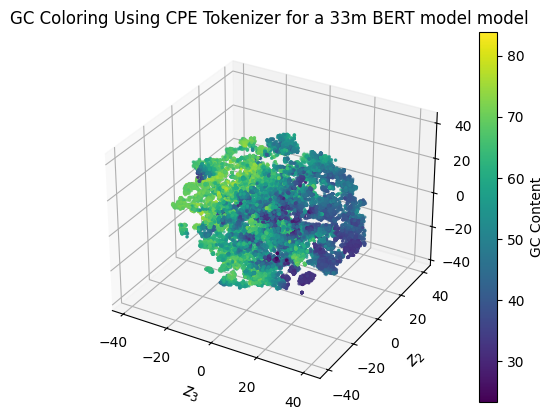

In [49]:
plot_3d_scatter(plot_df, hue, plt_title, cbar_label)

In [50]:
seq_lens = [len(seq) for seq in sequences]

hue = seq_lens
plt_title = f"Sequence Lengths Coloring Using {tokenizer_type} for a {model_type_with_params} model"

cbar_label = 'Sequence Length'


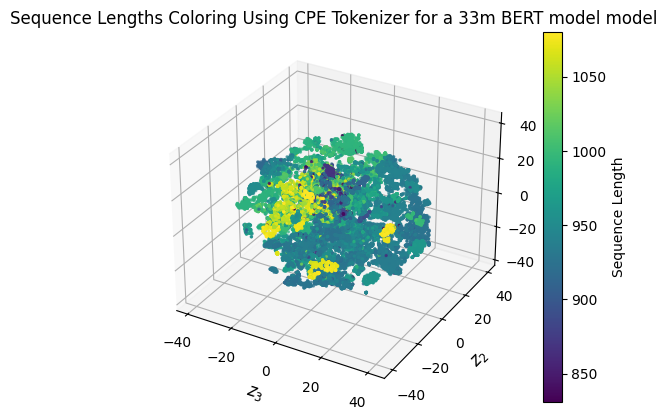

In [51]:
plot_3d_scatter(plot_df, hue, plt_title, cbar_label)

In [14]:
def plot_clusters(plot_df, hue, plt_title, color_label):
    """
    Create a 2D scatter plot with colors and a color bar.
    Parameters:
        x: x-axis data
        y: y-axis data
        colors: color data for each point
        color_label: label for the color bar
    """
    
    sc = plt.scatter(plot_df['x'], plot_df['y'], c=hue, cmap='viridis', s=10)
    # Add color bar
    cbar = plt.colorbar(sc)
    cbar.set_label(color_label)
    # Set axis labels
    plt.xlabel(r"$z_1$", fontsize=12)
    plt.ylabel(r"$z_2$", fontsize=12)
    # Set plot title if needed
    plt.title(plt_title)
    # Show the plot
    plt.show(block=False)


In [ ]:
plot_3d_clusters

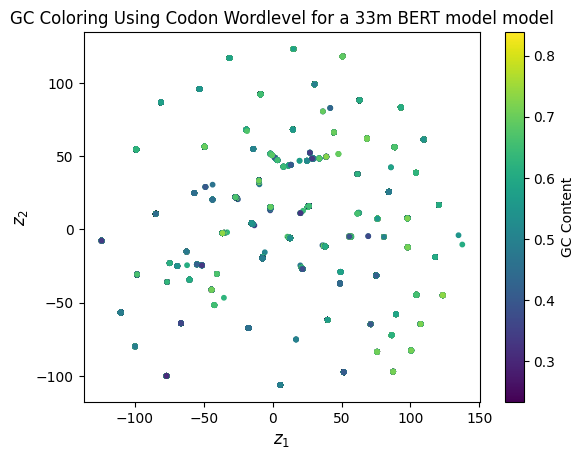

In [15]:
# plotting all sequences colored with gc content
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_gc_content()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

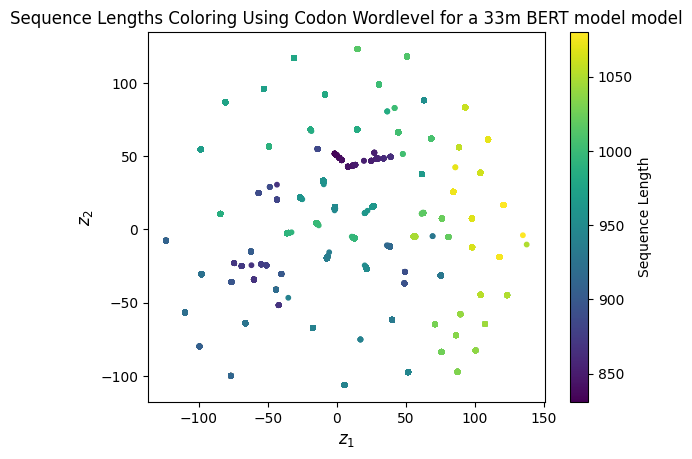

In [23]:
# plotting all sequences colored with sequence length
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_seq_len()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

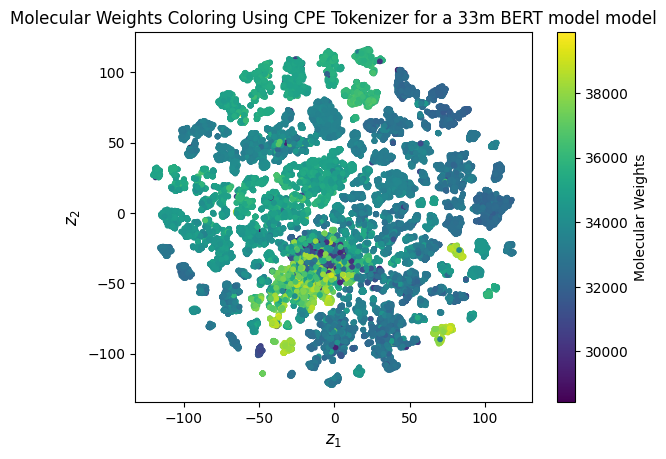

In [24]:
# plotting all sequences colored with molecular weight
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_molecular_weight()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

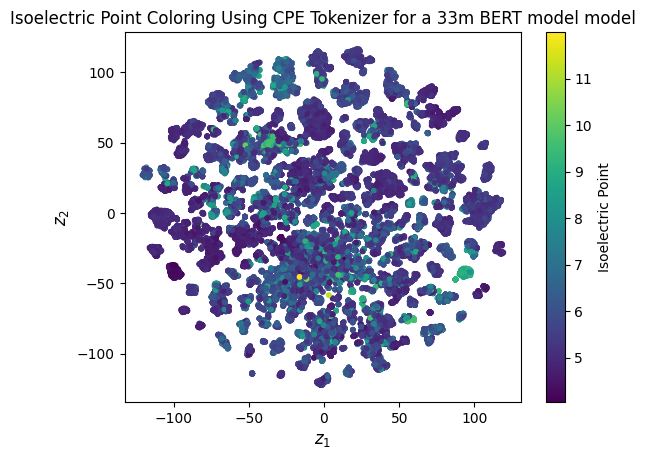

In [25]:
# plotting all sequences colored with isoelectric point
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_isoelectric_point()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

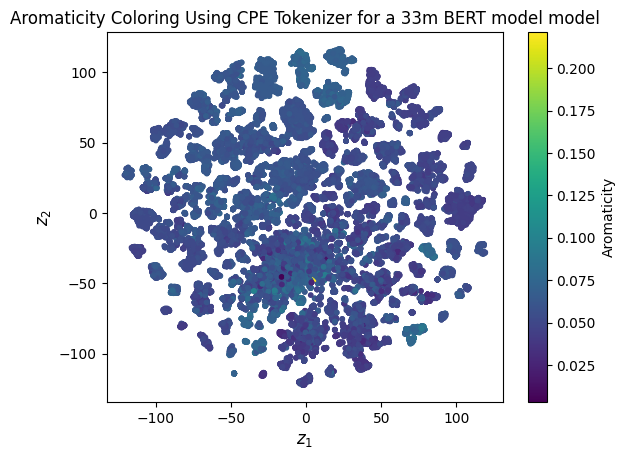

In [26]:
# plotting all sequences colored with aromaticity
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_aromaticity()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

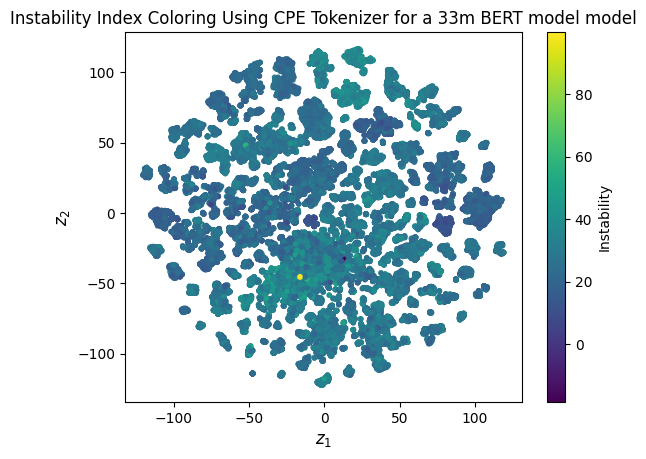

In [28]:
# plotting all sequences colored with instability index
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_instability_index()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

In [29]:
# plotting all sequences colored with flexibility
(
    plot_df_separate,
    hue_separate,
    plt_title,
    cbar_label
) = embedding_visualization.plot_flexibility()

plot_clusters(plot_df=plot_df_separate, hue=hue_separate, plt_title=plt_title, color_label=cbar_label)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, labels, stratify=labels, random_state=1
)
clf = MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)
print(f"MLP model train accuracy: {clf.score(X_train, y_train)}")
print(f"MLP model test accuracy: {clf.score(X_test, y_test)}")

In [61]:
import json
with open('/home/couchbucks/Documents/saketh/cpe/examples/determining_vocab_size/mdh_eval/mean_seq_len_experiment/npe_tokenizer_mean_seq_len_experiment.json') as json_file:
    data = json.load(json_file)

In [58]:
data

[{'vocab_size': 20, 'mean_tokenized_sequence_len': 324.30960115748957},
 {'vocab_size': 40, 'mean_tokenized_sequence_len': 292.09472850864023},
 {'vocab_size': 60, 'mean_tokenized_sequence_len': 262.4138844148399},
 {'vocab_size': 80, 'mean_tokenized_sequence_len': 242.11102618001146},
 {'vocab_size': 100, 'mean_tokenized_sequence_len': 228.85168300073707},
 {'vocab_size': 200, 'mean_tokenized_sequence_len': 193.10043405858426},
 {'vocab_size': 300, 'mean_tokenized_sequence_len': 175.84245584341133},
 {'vocab_size': 400, 'mean_tokenized_sequence_len': 164.30471458600638},
 {'vocab_size': 500, 'mean_tokenized_sequence_len': 156.04002074745435},
 {'vocab_size': 600, 'mean_tokenized_sequence_len': 149.742922661134},
 {'vocab_size': 700, 'mean_tokenized_sequence_len': 144.65253473833639},
 {'vocab_size': 800, 'mean_tokenized_sequence_len': 140.36417242226528},
 {'vocab_size': 900, 'mean_tokenized_sequence_len': 136.6576397040758},
 {'vocab_size': 1000, 'mean_tokenized_sequence_len': 133.40